<a href="https://colab.research.google.com/github/Dalia-Sher/Generating-Facial-Expressions-Bidirectional-cGAN/blob/Shir/GAN_cGan_Facial_images_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing relevant libraries

import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from IPython import display
from numpy import expand_dims, zeros, ones
from numpy.random import randn, randint
from keras.optimizers import Adam
from keras.models import Sequential, load_model
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout 

## Dataset

In [2]:
# data from: https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/
# code from: https://www.tensorflow.org/tutorials/generative/dcgan

#data = pd.read_csv('C:/Users/97254/Documents/Generative_Models/project/datasets/fer2013.csv')
data = pd.read_csv('fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
data.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [4]:
num_classes = 7
img_width = 48
img_height = 48

In [5]:
data.shape

(35887, 3)

In [6]:
X = data['pixels']
y = data['emotion']

In [7]:
X_train = []
for i in X:
    X_train.append([int(j) for j in i.split()])

X_train = np.array(X_train)/255.0

In [11]:
X_train = X_train.reshape(X_train.shape[0], img_width, img_height, 1)
X_train = X_train.astype('float32')

In [12]:
X_train.shape

(35887, 48, 48, 1)

In [13]:
# BUFFER_SIZE = 60000
# BATCH_SIZE = 256

In [14]:
# Batch and shuffle the data
#train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Discriminator Model

In [15]:
# define the standalone discriminator model
def define_discriminator(in_shape=(48,48,1)):
    model = Sequential()
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

## Generator Model

In [18]:
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 12x12 image
    n_nodes = 128 * 12 * 12
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((12, 12, 128)))
    # upsample to 24x24
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 48x48
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # generate
    model.add(Conv2D(1, (12, 12), activation='tanh', padding='same'))
    return model

In [23]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [24]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return X, y

In [26]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [27]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n_samples, 1))
	return X, y

In [28]:
# noise_dim = 100
# num_examples_to_generate = 16
# seed = tf.random.normal([num_examples_to_generate, noise_dim])

latent_points = generate_latent_points(100, 16)

In [29]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [31]:
# create and save a plot of generated images (reversed grayscale)
def show_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()

In [32]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        start = time.time()
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
        #display.clear_output(wait=True)
        #latent_points = generate_latent_points(latent_dim, 10)
        #show_plot(g_model.predict(latent_points), 4)
        # summarize loss on this epoch
        print('Time for epoch %d: %.3f sec d1=%.3f d2=%.3f g=%.3f' % (i + 1, time.time() - start, d_loss1, d_loss2, g_loss))
      # Generate after the final epoch

    # save the generator model
    g_model.save('generator.h5')

In [33]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = X_train
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

Time for epoch 1: 89.227 sec d1=0.749 d2=0.633 g=0.784
Time for epoch 2: 79.127 sec d1=0.691 d2=0.698 g=0.692
Time for epoch 3: 79.014 sec d1=0.698 d2=0.692 g=0.699
Time for epoch 4: 79.071 sec d1=0.694 d2=0.695 g=0.696
Time for epoch 5: 79.098 sec d1=0.698 d2=0.690 g=0.701
Time for epoch 6: 78.990 sec d1=0.690 d2=0.703 g=0.695
Time for epoch 7: 78.885 sec d1=0.686 d2=0.696 g=0.696
Time for epoch 8: 78.829 sec d1=0.730 d2=0.660 g=0.738
Time for epoch 9: 79.005 sec d1=0.692 d2=0.691 g=0.701
Time for epoch 10: 78.804 sec d1=0.692 d2=0.700 g=0.698
Time for epoch 11: 78.284 sec d1=0.685 d2=0.710 g=0.687
Time for epoch 12: 78.364 sec d1=0.693 d2=0.693 g=0.696
Time for epoch 13: 78.065 sec d1=0.696 d2=0.694 g=0.696
Time for epoch 14: 78.551 sec d1=0.693 d2=0.694 g=0.698
Time for epoch 15: 78.388 sec d1=0.695 d2=0.695 g=0.695
Time for epoch 16: 78.452 sec d1=0.696 d2=0.692 g=0.698
Time for epoch 17: 78.494 sec d1=0.693 d2=0.696 g=0.695
Time for epoch 18: 78.719 sec d1=0.696 d2=0.689 g=0.702
T

In [35]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

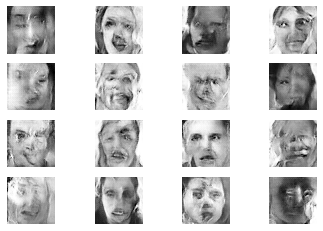

In [36]:
# create and save a plot of generated images (reversed grayscale)
def show_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()

# load model
model = load_model('generator.h5')
# generate images
latent_points = generate_latent_points(100, 16)
# generate images
X = 255-model.predict(latent_points)                #switching black and white
# plot the result
show_plot(X, 4)

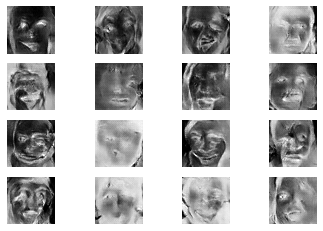

In [37]:
# load model
model = load_model('generator.h5')
# generate images
latent_points = generate_latent_points(100, 16)
# generate images
X = model.predict(latent_points)
# plot the result
show_plot(X, 4)

## **conditional GAN**



In [38]:
# example of training an conditional gan on the fashion mnist dataset
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from numpy import expand_dims, zeros, ones, asarray
from numpy.random import randn, randint
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D  
from keras.layers import Conv2DTranspose, LeakyReLU, Dropout
from keras.layers import Embedding, Concatenate

## Discriminator Model

In [39]:
# define the standalone discriminator model
def define_discriminator(in_shape=(48,48,1), n_classes=7):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)
	# image input
	in_image = Input(shape=in_shape)
	# concat label as a channel
	merge = Concatenate()([in_image, li])
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

## Generator Model

In [40]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=7):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 12 * 12
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((12, 12, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 12x12 image
	n_nodes = 128 * 12 * 12
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((12, 12, 128))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 24x24
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 48x48
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(1, (12,12), activation='tanh', padding='same')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

## Gan Model

In [41]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

## Load and generate samples

In [42]:
# load fashion mnist images
def load_real_samples():
    X_train = []
    for i in X:
        X_train.append([int(j) for j in i.split()])

    # scale from [0,255] to [-1,1]
    X_train = np.array(X_train) / 255.0
    #X_train = (np.array(X_train) - 127.5) / 127.5
    X_train = X_train.reshape(X_train.shape[0], img_width, img_height, 1)
    # convert from ints to floats
    X_train = X_train.astype('float32')
    y_train = y
    return [X_train, y_train]

In [43]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

In [44]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=7):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

In [45]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

## Train

In [46]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
  bat_per_epo = int(dataset[0].shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    start = time.time()
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
      # update discriminator model weights
      d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
      # generate 'fake' examples
      [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # update discriminator model weights
      d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
      # prepare points in latent space as input for the generator
      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
        # summarize loss on this batch
        #print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    print('Time for epoch %d: %.3f sec d1=%.3f d2=%.3f g=%.3f' % (i + 1, time.time() - start, d_loss1, d_loss2, g_loss))
  # save the generator model
  g_model.save('cgan_generator.h5')

In [47]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
#dataset = load_real_samples()
dataset = [X_train, y]
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Time for epoch 1: 89.409 sec d1=0.579 d2=0.782 g=0.778
Time for epoch 2: 87.182 sec d1=0.631 d2=0.688 g=0.893
Time for epoch 3: 87.299 sec d1=0.616 d2=0.685 g=0.939
Time for epoch 4: 87.271 sec d1=0.678 d2=0.656 g=0.900
Time for epoch 5: 87.522 sec d1=0.698 d2=0.639 g=0.882
Time for epoch 6: 87.304 sec d1=0.676 d2=0.724 g=0.871
Time for epoch 7: 87.363 sec d1=0.660 d2=0.632 g=0.875
Time for epoch 8: 87.103 sec d1=0.645 d2=0.639 g=0.898
Time for epoch 9: 86.942 sec d1=0.623 d2=0.617 g=0.850
Time for epoch 10: 86.950 sec d1=0.637 d2=0.643 g=0.978
Time for epoch 11: 87.093 sec d1=0.694 d2=0.706 g=0.894
Time for epoch 12: 87.167 sec d1=0.662 d2=0.675 g=0.862
Time for epoch 13: 87.203 sec d1=0.645 d2=0.627 g=0.982
Time for epoch 14: 87.064 sec d1=0.686 d2=0.644 g=0.850
Time for epoch 15: 87.291 sec d1=0.660 d2=0.667 g=0.813
Time for epoch 16: 87.162 sec d1=0.630 d2=0.654 g=0.892
Time for epoch 17: 87.025 sec d1=0.621 d2=0.696 g=0.865
Time for epoch 18: 86.592 sec d1=0.650 d2=0.673 g=0.984
T

## Generate Results

In [48]:
def plot_images(model, predictions):
  fig = plt.figure(figsize=(7,7))
  for i in range(predictions.shape[0]):
      plt.subplot(7, 7, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('generated_images.png')
  plt.show()

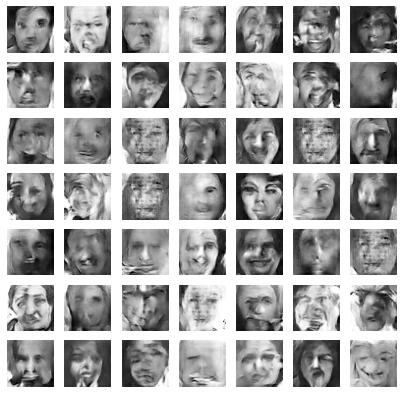

In [49]:
# load model
model = load_model('cgan_generator.h5')
# generate images
latent_points, labels = generate_latent_points(100, 49)
# generate images
predictions = model.predict([latent_points, labels])
# plot the result
plot_images(model, predictions)